### <center>THE ULTIMATE CHALLENGE</center>
#### The Ultimate Challenge is a mini project, in which two datasets are comined to give an insight. The two datasets to use are the logins and Ultimate challenge.

In [1]:
# Useful python libraries to use for this processing
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('ggplot')

In [2]:
#  Importing, converting and logins json file.
with open("/Users/owner/Desktop/logins.json") as f:
    data = json.load(f)
data = pd.DataFrame(data)
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
data['login_time'] = pd.to_datetime(data['login_time'])

### Daily Logins Patterns

In [4]:
# Lets aggregate the data by date
data = data.set_index('login_time')
data['data'] = 1
logins = data.resample('1D').sum()
logins.head()

,data
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


In [5]:
print('{} Total Number of logins from {} days'.format(logins.data.sum(), len(logins)))

93142 Total Number of logins from 103 days


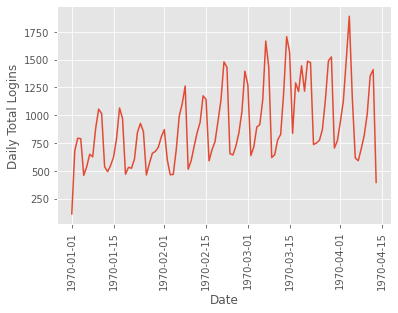

In [6]:
# Show daily login patterns
ax = plt.plot(logins)
ax = plt.xticks(rotation = 90)
ax = plt.xlabel('Date')
ax = plt.ylabel('Daily Total Logins')

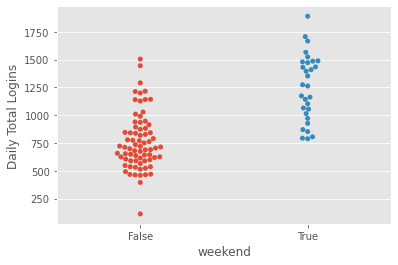

In [7]:
# Visualize the logins based on weekdays and weekend
logins['weekend'] = logins.index.weekday >= 5
ax=sns.swarmplot(x='weekend', y='data', data=logins)
ax=plt.ylabel("Daily Total Logins")

In [8]:
# Checking for any significant difference between weekday and weekend daily logins
from scipy.stats import ttest_ind
weekend = logins.loc[logins.weekend == True, 'data']
weekday = logins.loc[logins.weekend == False, 'data']
t,p = ttest_ind(weekend, weekday)
print('t = {}\tp = {}'.format(t,p))

t = 8.46472731224942	p = 2.113648536307778e-13


#### Above results show that the daily logins were more during the weekend than during the weekday.
#### Next Hourly Patterns

In [9]:
# Differentiating weekdays and weekends
weekday = data.loc[data.index.weekday<5]
weekend = data.loc[data.index.weekday>=5]

#sum for every 15mins intervals
weekday = weekday.resample('15T').sum()
weekend = weekend.resample('15T').sum()

# Determine the average of logins per time frame
weekday['time']= weekday.index.time
weekend['time']= weekend.index.time

# Groupby time
weekday = weekday.groupby('time')['data'].mean()
weekend = weekend.groupby('time')['data'].mean()

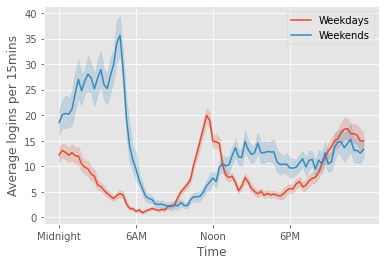

In [10]:
# Lets visualize the logins for every 15mins
logins = data.resample('15T').sum()
logins['time'] = logins.index.time
logins['time'] = logins['time'].astype('category')
logins['weekend'] = logins.index.weekday >=5
logins.head()
ax = sns.lineplot(x = 'time', y = 'data', hue = 'weekend', data = logins)
ax = plt.xticks(['00:00:00', '06:00:00', '12:00:00','18:00:00'], ['Midnight', '6AM', 'Noon','6PM'])
ax = plt.xlabel('Time')
ax = plt.ylabel('Average logins per 15mins')
ax = plt.legend(['Weekdays', 'Weekends'])

### Ultimate Challenge Modelling

In [11]:
# Importing, converting and viewing ultimate challenge json file.
with open('/Users/owner/Desktop/ultimate_data_challenge.json') as f:
    ultimate = json.load(f)
ultimate = pd.DataFrame(ultimate)
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
# We convert date columns to datetime
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])
ultimate['signup_date'] = pd.to_datetime(ultimate['signup_date'])
print('Range of sign up dates is between {} and {}'
     .format(ultimate['signup_date'].min(), ultimate['signup_date'].max()))

Range of sign up dates is between 2014-01-01 00:00:00 and 2014-01-31 00:00:00


In [13]:
# Calculate if a user is active in the 6th month.
ultimate['active'] = ultimate['last_trip_date']>=pd.to_datetime('2014-06-01')
# Drop dates columns that won't be used again.
ultimate.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)
# Convert boolean columns into int.
ultimate['ultimate_black_user'] = ultimate['ultimate_black_user'].astype(int)
ultimate['active'] = ultimate['active'].astype(int)
# See how many users were retained.
print('Out of {} users, {} were still active in their 6th month.'
     .format(len(ultimate), ultimate['active'].sum()))

Out of 50000 users, 18804 were still active in their 6th month.


### Exploratory data analysis

In [14]:
# Determine which attributes have strrongest correlaion with retention
ultimate.corr()['active']

trips_in_first_30_days    0.210463
avg_rating_of_driver     -0.011653
avg_surge                -0.003333
surge_pct                 0.011797
ultimate_black_user       0.205002
weekday_pct               0.009693
avg_dist                 -0.092780
avg_rating_by_driver     -0.026791
active                    1.000000
Name: active, dtype: float64

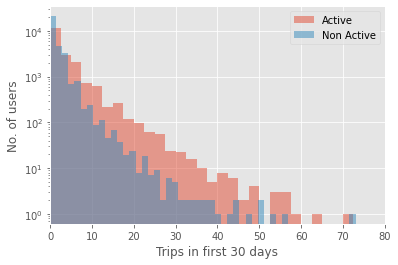

In [15]:
# Visual representation.
active = ultimate.loc[ultimate.active==1]
non_active = ultimate.loc[ultimate.active==0]
_ = plt.hist(active['trips_in_first_30_days'], bins=50, alpha=0.5, label='Active')
_ = plt.hist(non_active['trips_in_first_30_days'], bins=50, alpha=0.5, label='Non Active')
_ = plt.xlabel('Trips in first 30 days')
_ = plt.ylabel('No. of users')
_ = plt.xlim([0,80])
_ = plt.yscale('log')
_ = plt.legend()

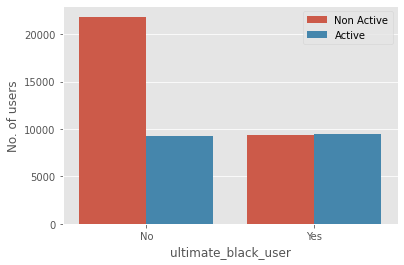

In [16]:
# Active ultimate_black_user
ax = sns.countplot(x='ultimate_black_user', hue='active', data=ultimate)
ax = plt.legend(['Non Active', 'Active'])
ax = plt.ylabel('No. of users')
ax = plt.xticks([0,1],['No','Yes'])

In [17]:
# Chi-square test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(ultimate['ultimate_black_user'], ultimate['active'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 2100.4182024974366	p = 0.0


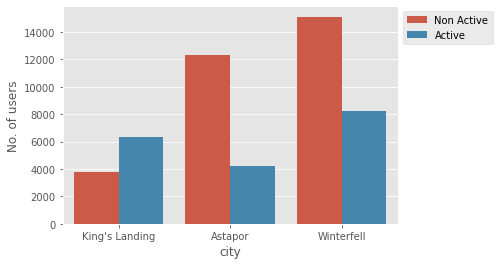

In [18]:
# Visualize the two categorical features, city and phone
ax = sns.countplot(x='city', hue='active', data=ultimate)
ax = plt.legend(['Non Active', 'Active'], bbox_to_anchor=(1,1))
ax = plt.ylabel('No. of users')

In [19]:
# Chi-square test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(ultimate['city'], ultimate['active'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 3821.5510225559638	p = 0.0


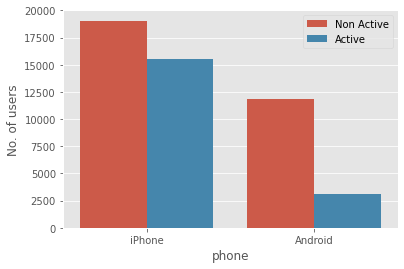

In [20]:
# Phone feature
ax = sns.countplot(x='phone', hue='active', data=ultimate)
ax = plt.legend(['Non Active', 'Active'])
ax = plt.ylabel('No. of users')

In [21]:
# Chi-square test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(ultimate['phone'], ultimate['active'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 2558.3942122674252	p = 0.0


### data wrangling and preprocessing

In [22]:
ultimate.info(), ultimate.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   49604 non-null  object 
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  int32  
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    49799 non-null  float64
 10  active                  50000 non-null  int32  
dtypes: float64(6), int32(2), int64(1), object(2)
memory usage: 3.8+ MB


(None,
        trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
 count            50000.000000          41878.000000  50000.000000   
 mean                 2.278200              4.601559      1.074764   
 std                  3.792684              0.617338      0.222336   
 min                  0.000000              1.000000      1.000000   
 25%                  0.000000              4.300000      1.000000   
 50%                  1.000000              4.900000      1.000000   
 75%                  3.000000              5.000000      1.050000   
 max                125.000000              5.000000      8.000000   
 
           surge_pct  ultimate_black_user   weekday_pct      avg_dist  \
 count  50000.000000          50000.00000  50000.000000  50000.000000   
 mean       8.849536              0.37708     60.926084      5.796827   
 std       19.958811              0.48466     37.081503      5.707357   
 min        0.000000              0.00000      0.000000      0.000000

In [23]:
# Impute ratings with median.
ultimate.fillna({'avg_rating_by_driver':ultimate['avg_rating_by_driver'].median()}, inplace=True)
ultimate.fillna({'avg_rating_of_driver':ultimate['avg_rating_of_driver'].median()}, inplace=True)
# Cannot impute phone types, drop those rows instead.
ultimate.dropna(inplace=True)

In [24]:
# Separate the target data
target = ultimate['active']
ultimate.drop('active', axis=1, inplace=True)
# Transform categorical data into dummy variables
ultimate['iphone'] = pd.get_dummies(ultimate['phone'], drop_first=True)
ultimate.drop('phone', axis=1, inplace=True)
ultimate = pd.concat([ultimate, pd.get_dummies(ultimate['city'], drop_first=True)], axis=1)
ultimate.drop('city', axis=1, inplace=True)
# Sclae the features
from sklearn.preprocessing import scale
scaled_ultimate = pd.DataFrame(scale(ultimate))
scaled_ultimate.columns = ultimate.columns
scaled_ultimate.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,iphone,King's Landing,Winterfell
0,0.454159,0.087233,0.112318,0.326417,1.290412,-0.395941,-0.373113,0.495597,0.659081,1.981887,-0.934523
1,-0.600342,0.608234,-0.336789,-0.444014,-0.774946,-0.293477,0.436461,0.495597,-1.517264,-0.504570,-0.934523
2,0.190534,-0.607435,-0.336789,-0.444014,-0.774946,1.054746,-0.884608,0.495597,0.659081,-0.504570,-0.934523
3,1.772286,-0.086434,0.291961,0.556545,1.290412,0.515457,-0.604167,0.271601,0.659081,1.981887,-0.934523
4,3.090412,-0.433768,0.516515,0.146316,-0.774946,0.580172,-0.468357,0.271601,-1.517264,-0.504570,1.070064


In [25]:
# Split training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_ultimate, target, random_state=42)

### Random Forest Classifier

In [26]:
# RANDOM FOREST CLASSIFIER
# INSTANTIATE THE RANDOM FOREST CLASSIFIER
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
    
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
X,y = make_classification(n_samples = 1000, n_features = 4,
                         n_informative = 2, n_redundant = 0,
                         random_state = 0, shuffle = False)

In [27]:
# USING xgboost Classifier
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
params = {'objective': 'binary:hinge', 'missing': 1, 'seed': 42
         }

In [28]:
# Instantiate the XGBOOST Classifier
clf = XGBClassifier(**params)
clf.fit(X_train, y_train)

# Prediction with the XGBoost Classifier
y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]

In [29]:
score = clf.score(X_train, y_train)
score_a = clf.score(X_test, y_test)
print("TRAINING SET ACCURACY: ", '%.3f' %(score))
print("TEST SET ACCURACY: ", '%.3f' %(score_a))

TRAINING SET ACCURACY:  0.811
TEST SET ACCURACY:  0.786


In [30]:
# Metric evaluation
import sklearn.metrics as metrics
actual_y = y_test
predicted_y = y_pred

print(metrics.classification_report(actual_y, predicted_y))

cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      7750
           1       0.72      0.69      0.71      4651

    accuracy                           0.79     12401
   macro avg       0.77      0.77      0.77     12401
weighted avg       0.78      0.79      0.78     12401

[[6529 1221]
 [1438 3213]]


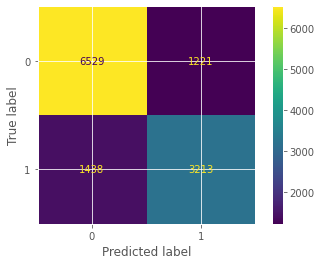

In [31]:
# Plotting the confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

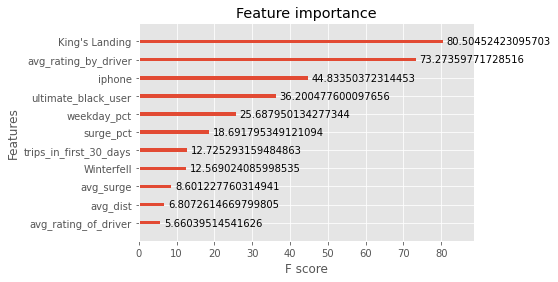

In [32]:
# Determine the feature importance
import xgboost as xgb
xgb.plot_importance(clf, importance_type = 'gain')

### The above feature importance demonstrates features that played great for the attrition that were shown in the confusion matrix. Five of these features are shown with high number of F-score. These are King's Landing, avg_rating_by_driver, iphone, ultimate_black_user, and weekday_pct.